In [18]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm

In [26]:
tf.keras.backend.set_floatx("float64")
 
class DNModel(tf.keras.Model):
    def __init__(self):
        super(DNModel, self).__init__()

        self.dense1 = tf.keras.layers.Dense(32)
        self.dense2 = tf.keras.layers.Dense(32)
        self.out = tf.keras.layers.Dense(1)

    def call(self, x):
        x = tf.nn.tanh(self.dense1(x))
        x = tf.nn.tanh(self.dense2(x))

        return tf.math.exp(self.out(x))

    
    
    
@tf.function
def loss(model, x):
    with tf.GradientTape() as g:
        g.watch(x)
        with tf.GradientTape() as gg:
            gg.watch(x)
            psi = model(x)


        d_psi = gg.gradient(psi, x)
    d2_psi = g.gradient(d_psi, x)
    
    E_L = -0.5*1/psi*d2_psi + 0.5*x**2
    E_L = tf.stop_gradient(E_L)
    E = tf.math.reduce_mean(E_L)
    
    psi_detach = tf.stop_gradient(psi)
    return E, 2*(tf.math.reduce_mean(psi/psi_detach*E_L) - tf.math.reduce_mean(psi/psi_detach)*E)


@tf.function
def grad(model, x):
    with tf.GradientTape() as tape:
        E, loss_value = loss(model, x)

    return E, tape.gradient(loss_value, model.trainable_variables)



def sample(model, N, n):
    total = 0
    x_old = tf.random.uniform((N,1), minval=-2, maxval=2, dtype=tf.dtypes.float64)
    psi_old = model(x_old).numpy()
    
    for i in range(n):
        x_new = x_old + 2*tf.random.uniform((N,1), minval=-1, maxval=1, dtype=tf.dtypes.float64)
        psi_new = model(x_new).numpy()
      
    
        U = np.random.uniform(0, 1, (N,1))
        mask = ((psi_new/psi_old)**2 > U) #vectorized acceptance criterion
        x_old = x_old.numpy()
        x_new = x_new.numpy()
        
        x_old[mask]   = x_new[mask]  #move walkers
        psi_old[mask] = psi_new[mask]
        x_old = tf.convert_to_tensor(x_old, dtype=tf.dtypes.float64)
        total += np.sum(mask)
    
    return x_old, total

In [27]:
tf.random.set_seed(42)
np.random.seed(42)
model = DNModel()
optimizer = tf.keras.optimizers.Adam(0.01)

N = 1000
num_epochs = 400
energy = []

for epoch in range(num_epochs):
    x = sample(model, N, 10)[0]

    E, gradients = grad(model, x)
    energy.append(E)
    
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    
    if epoch%20 == 0: 
        print(f"epoch: {epoch}, Energy: {E}")

epoch: 0, Energy: 8.025595740839318
epoch: 20, Energy: 2.126550385154276
epoch: 40, Energy: 0.6926804539606587
epoch: 60, Energy: 0.5199469728787156
epoch: 80, Energy: 0.5066469827811281
epoch: 100, Energy: 0.5042840725978996
epoch: 120, Energy: 0.5008868368288145
epoch: 140, Energy: 0.4992583722011169
epoch: 160, Energy: 0.4994907441036836
epoch: 180, Energy: 0.5035790340042386
epoch: 200, Energy: 0.5036477541727701
epoch: 220, Energy: 0.5019409528108761
epoch: 240, Energy: 0.5147248524750461
epoch: 260, Energy: 0.5236350804607433
epoch: 280, Energy: 0.4977203090604107
epoch: 300, Energy: 0.4965894732222671
epoch: 320, Energy: 0.5002329660997791
epoch: 340, Energy: 0.5034345977960986
epoch: 360, Energy: 0.5013375465356926
epoch: 380, Energy: 0.5000677349162377


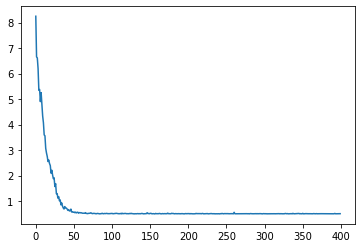

In [16]:
plt.plot(energy)
plt.show()

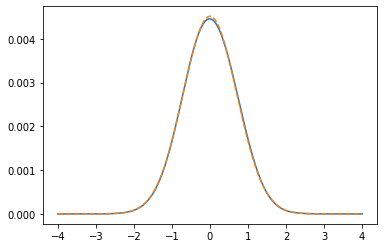

In [28]:
x_lin = np.linspace(-4, 4, 1000)
tf_x_lin = tf.convert_to_tensor(x_lin.reshape(-1,1), dtype=tf.dtypes.float64)

psi1 = model(tf_x_lin).numpy()[:, 0]
psi2 = np.exp(-0.5*x_lin**2)

plt.plot(x_lin, psi1**2/np.sum(psi1**2))
plt.plot(x_lin, psi2**2/np.sum(psi2**2), "--")
plt.show()

In [ ]:
x = tf.convert_to_tensor([[1, 2], [3, 4], [5, 6]], dtype=tf.dtypes.float64)


with tf.GradientTape() as g:
    g.watch(x)
    f = x[:,0]**2 + tf.reduce_sum(x**2, axis = 1)

d_f = g.gradient(f, x)
    
print(d_f)